![STScI Logo](../../../_static/stsci_header.png)

<a id="titleSaturation"></a>
# ACS Linearity with Saturated Stars

## Table of Contents

[Introduction](#intro_ID) <br>
[Imports](#imports) <br>
[Download the Data](#download) <br>
[File Information](#_fileinfo) <br>
[1. Prepare Images](#_prep) <br>
[2. Identify Saturated Stars](#_identify) <br>
[3. Bleed the Saturation Mask](#_bleed) <br>
[4. Define a Custom Aperture](#_define) <br>
[5. Photometry with a Custom Aperture](#_phot) <br>
[6. Additional Results](#_results) <br>
[About this Noteboook](#about)

<a id="intro_ID"></a>
## Introduction

The ACS/WFC CCD becomes saturated around 80000 counts. When this occurs, excess charge from the source spills out lengthwise along the columns of the CCD. This can lead to issues with photometry when using very bright stars, since a significant portion of the star's flux may fall outside of a reasonable extraction radius. 

However, accurate relative photometry can be obtained as long as a large enough aperture is selected to contain the spilled flux ([ACS ISR 2004-01](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr0401.pdf)). While one could simply use a larger circular aperture, that may introduce error when working with a crowded field (where bright stars are often located).

Here we present a method to identify and perform photometry on saturated sources by defining a custom aperture that is a combination of a standard 0.5" arcsecond circular aperture and the pixels affected by saturation trails. This method has been tested on ACS/WFC observations of 47 Tuc in the F606W band. The plot below shows the results of using this alternative method to recover flux. 

<img src=photometry_recovery.png width ="900" title="" alt="">


### This tutorial will show you how to...

#### 1. [Prepare Images](#_prep) 

* Apply Pixel Area Map
* Separate by long and short exposure
* Make sure you have images of the same field

#### 2. [Identify Saturated Stars](#_identify)

* Identify the saturated pixels using the data quality (DQ) array
* Determine whether or not the saturation trails extend significantly away from the target

#### 3. [Bleed the Saturation Mask](#_bleed)

* Construct a convolution kernel
* Bleed the saturation mask with the convolution kernel

#### 4. [Define a Custom Aperture](#_define)

* Isolate central clump from your saturation mask
* Obtain circular aperture as a boolean mask
* Combine circular aperture with saturation mask

#### 5. [Photometry with a Custom Aperture](#_phot)

* Extract counts with the custom aperture
* Estimate background to be subtracted

#### 6. [Additional Results](#_results)

* A worked example with several stars

<a id="imports"></a>
## Imports

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
|`shutil`          | `rmtree`           | <a class="divlink" href="https://docs.python.org/2/library/shutil.html#shutil.rmtree">link</a>| remove directory tree |
|`numpy`           | `_s`               | <a class="divlink" href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.s_.html">link</a>| construct array slice object |
|`matplotlib`      |`pyplot`    | <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.colors.LogNorm.html#matplotlib.colors.LogNorm">link</a>| plotting |
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files |
|`astropy.table`   | `Table`            | <a class="divlink" href="http://docs.astropy.org/en/stable/table/">link</a>| constructing and editing in a tabular format |
|`astropy.stats`   |`sigma_clip`| <a class="divlink" href="http://docs.astropy.org/en/stable/api/astropy.stats.sigma_clip.html">link</a>| sigma clipping image for background estimation |
|`scipy.signal`    |`convolve2d`| <a class="divlink" href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html">link</a>| convolve saturation mask with kernel |
|`stsci.skypac`    |`pamutils`| <a class="divlink" href="https://stsci-skypac.readthedocs.io/en/stable/_modules/stsci/skypac/pamutils.html">link</a>|obtain pixel area maps (PAM) |
|`photutils`       |`CircularAperture`| <a class="divlink" href="https://photutils.readthedocs.io/en/stable/api/photutils.aperture.CircularAperture.html">link</a>| aperture object for photometry |
|`matplotlib.patches`|`Circle`| <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.patches.Circle.html">link</a>| draw circle on a plot |

In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

from astroquery.mast import Observations

from astropy.io import fits
from astropy.table import Table, unique
from astropy.stats import sigma_clip

from scipy.signal import convolve2d
from stsci.skypac import pamutils

from photutils.aperture import CircularAperture
from matplotlib.patches import Circle
from p_module import plot



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


Here we set environment variables for later use with the Calibration Reference Data System (CRDS).

In [2]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['jref'] = './crds_cache/references/hst/acs/'

<a id="download"></a>
## Download the Data

Here we download all of the data required for this notebook. This is an important step! Some of the image processing steps require all relevant files to be in the working directory. We recommend working with a brand new directory for every new set of data.

### [GO Proposal 14949](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=14949): "ACS External CTE Monitor"

Using the python package `astroquery`, we can download files from the [MAST](http://archive.stsci.edu) archive.

<div class="alert alert-danger">
<b>MAY CHANGE:</b> The argument "mrp_only" stands for "minimum recommended products only". It currently needs to be set to False, although in the future, False is intended to be set as the default and can be left out.
</div>

In [3]:
obs_table = Observations.query_criteria(proposal_id=14949, filters='F606W')

dl_table = Observations.download_products(obs_table['obsid'], project=['CALACS'],
                                          productSubGroupDescription=['FLC'],
                                          mrp_only=False)
unique_table = unique(dl_table, keys='Local Path')

INFO: 18 of 36 products were duplicates. Only returning 18 unique product(s). [astroquery.mast.utils]

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


We'll use the package `os` to put all of these files in our working directory for convenience.

In [4]:
for row in unique_table:
    oldfname = row['Local Path']
    unique_fname = np.unique(oldfname)
    newfname = os.path.basename(oldfname)
    print(row)
    os.rename(oldfname, newfname)

                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg301bwq/jdg301bwq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg301byq/jdg301byq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg301c4q/jdg301c4q_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg301c6q/jdg301c6q_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/j

                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg302cnq/jdg302cnq_flc.fits COMPLETE    None None


                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg302ctq/jdg302ctq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg302cvq/jdg302cvq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg302cxq/jdg302cxq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg302czq/jdg302czq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/j

                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg303dbq/jdg303dbq_flc.fits COMPLETE    None None


                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg303dlq/jdg303dlq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jdg303dnq/jdg303dnq_flc.fits COMPLETE    None None


Now that all of our files are in the current working directory, we delete the leftover MAST file structure.

In [5]:
shutil.rmtree('mastDownload')

<a id="_fileinfo"></a>
## File Information
The structure of the fits files from ACS may be different depending on what kind of observation was made. 
For more information, refer to Section 2.2 of the [ACS Data Handbook](https://hst-docs.stsci.edu/acsdhb/chapter-2-acs-data-structure/2-2-acs-file-structure).

#### Raw Files

A standard raw image file from a subarray has the same structure as you'd expect from full frame observation from ACS/WCS.

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| SCI (Image)      | (ImageHDU)   | Raw image data.                                        |
|<b>2</b>| ERR (Error)      | (ImageHDU)   | Error array.                                           |
|<b>3</b>| DQ (Data Quality)| (ImageHDU)   | Data quality array.                                    |

#### SPT Files

SPT files contain telemetry and engineering data from the telescope.

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| UDL (Image)      | (ImageHDU)   | Raw image data.                                        |

You can always use `.info()` on an HDUlist for an overview of the structure.

In [6]:
with fits.open('jdg302ctq_flc.fits') as hdulist:
    hdulist.info()

Filename: jdg302ctq_flc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     326   ()      
  1  SCI           1 ImageHDU       248   (4096, 2048)   float32   
  2  ERR           1 ImageHDU        53   (4096, 2048)   float32   
  3  DQ            1 ImageHDU        45   (4096, 2048)   int16   
  4  SCI           2 ImageHDU       246   (4096, 2048)   float32   
  5  ERR           2 ImageHDU        53   (4096, 2048)   float32   
  6  DQ            2 ImageHDU        45   (4096, 2048)   int16   
  7  D2IMARR       1 ImageHDU        16   (64, 32)   float32   
  8  D2IMARR       2 ImageHDU        16   (64, 32)   float32   
  9  D2IMARR       3 ImageHDU        16   (64, 32)   float32   
 10  D2IMARR       4 ImageHDU        16   (64, 32)   float32   
 11  WCSDVARR      1 ImageHDU        16   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        16   (64, 32)   float32   
 13  WCSDVARR      3 ImageHDU        16   (64, 32)   float32   
 14  W

<a id="_prep"></a>
## 1. Prepare Images

For this notebook, we will need two well-aligned images of the same field on the sky. One image should have a short exposure time (eg. 40 seconds) and the other should have a long exposure time (eg. 400 seconds). Here we assume you already know which images those are, and set those observation files to appropriate variable names.

In [7]:
fname_short = 'jdg302ctq_flc.fits'
fname_long = 'jdg301c4q_flc.fits'

Before we use our images for photometry, we will need to apply a pixel area map (PAM) correction. This step corrects the difference in flux accross the CCD due to distortion. A dedicated notebook on PAM corrections can be found in the ACS notebook collection.

First, we will work with the short exposure image.

In [8]:
fitsfile = fname_short

Now we can extract the image from the fits file using the python package `fits`. Here, I use the name "raw_short" to indicate that this image has not had the PAM correction applied, and is the short exposure image.

In [9]:
raw_short = fits.getdata(fitsfile)

Now we need to obtain the PAM for this image using the python package `pamutils`. To contruct the new filename for the PAM, we will use the python package `os` to grab the basename of our fits file, and append '_pam.fits' at the end.

In [10]:
pname = os.path.basename(fitsfile).split('.')[0] + '_pam.fits'
print(pname)

jdg302ctq_flc_pam.fits


Now we can run `pam_from_file` on our fits file to create our PAM.

In [11]:
pamutils.pam_from_file(fitsfile, ext=1, output_pam=pname)

Once our PAM has been written to file, we can extract it with `fits` for later use.

In [12]:
pam_short = fits.getdata(pname)

Finally, we can apply the PAM corrections to our "raw" image.

In [13]:
img_short = raw_short * pam_short

There is one more array we'll need to extract from our fits file. The data quality (DQ) array labels saturated pixels with the flag number 256. As seen from our [file information](#_fileinfo), the DQ array can be found in extension 3 of the HDU list.

In [14]:
dq_short = fits.getdata(fitsfile, ext=3) == 256

Here I repeat all of the previous steps with the long exposure image, changing variable names where necessary.

In [15]:
fitsfile = fname_long

dq_long = fits.getdata(fitsfile, ext=3) == 256
raw_long = fits.getdata(fitsfile)

pname = os.path.basename(fitsfile).split('.')[0] + '_pam.fits'
pamutils.pam_from_file(fitsfile, ext=1, output_pam=pname)

pam_long = fits.getdata(pname)

img_long = raw_long * pam_long

<a id="_identify"></a>
## 2. Identify Saturated Stars 

Before we begin our modified aperture photometry routine, we should determine whether or not our sources are saturated. We can identify saturated stars by whether or not their saturation trails extend past a typical extraction radius.

Here we have the local coordinates of a bright star in our field.

In [16]:
local_coord = {'x': 1711, 'y': 225}

We will make cutouts around our source with a radius of 100 pixels. This size cutout is typically big enough to contain saturation trails from the brightest stars. We will also assume that our extraction aperture has a radius of 0.5 arcseconds. Knowing that the ACS pixel scale is ~20 pixels/arcsecond, we can calculate our aperture radius in pixels.

In [17]:
pix_per_arcsec = 20
cutout_radius = 100
aperture_radius = 0.5 * pix_per_arcsec

We can make a slice object with numpy to help make cutouts around our source. It will be convenient for us to define a function to construct a cutter object with `numpy`.

In [18]:
def make_cutter(x, y, cutout_radius=100):
    
    # Makes a 2D array slice object centered around x, y
    
    starty, endy = (y - cutout_radius), (y + cutout_radius)
    startx, endx = (x - cutout_radius), (x + cutout_radius)
    
    return np.s_[starty:endy, startx:endx]

Now we can take a cutout of our image around the source.

In [19]:
cutter = make_cutter(local_coord['x'], local_coord['y'])

Before we try out our cutter, let's take a look at our full frame image.

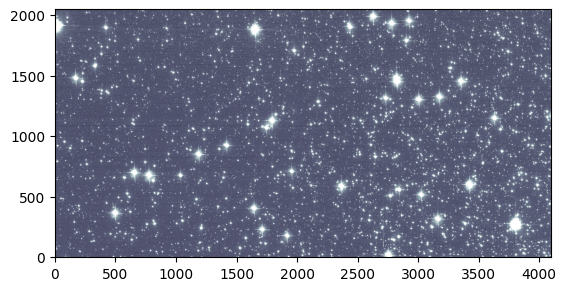

In [20]:
plot.ds9_imitate(plt, img_short)

Now by indexing our image with our cutter, we can grab just the cutout we need!

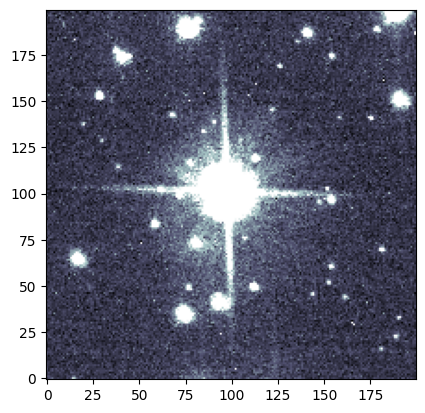

In [21]:
plot.ds9_imitate(plt, img_short[cutter])

We can visually confirm that this source is affected by saturation trails in the short exposure. What about the long exposure image? Since our images are aligned, we can use the same coordinates (and the same cutter!) as before.

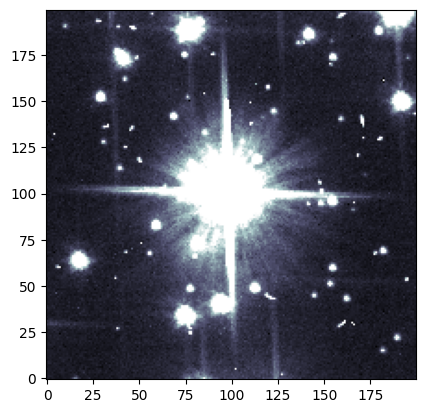

In [22]:
plot.ds9_imitate(plt, img_long[cutter])

We can also apply the same cutter to our DQ saturated pixel array!

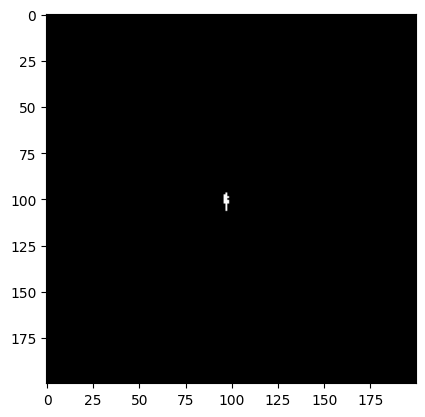

In [23]:
plt.imshow(dq_short[cutter], cmap='bone')

As we expect, we do not see very much saturation in our short exposure image. What about our long exposure image?

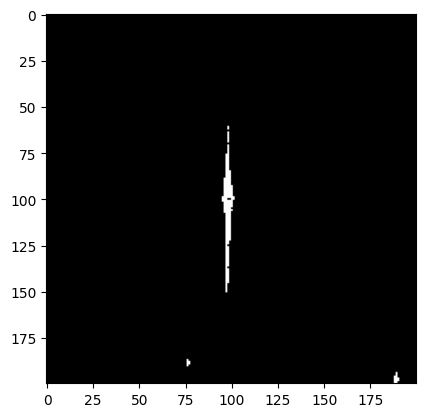

In [24]:
plt.imshow(dq_long[cutter], cmap='bone')

Now we see a large clump of saturated pixels spilling along the y-axis!

For both of these images, we want to see whether or not the saturated pixels fall outside the range of our typical 0.5" extraction radius.

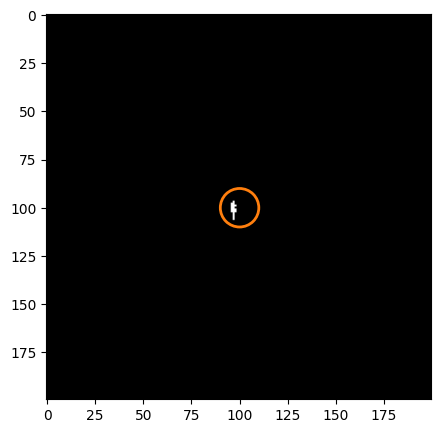

In [25]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)

circ_patch = Circle((cutout_radius, cutout_radius),
                    radius=aperture_radius,
                    color='C1',
                    linewidth=2,
                    fill=False)

ax.imshow(dq_short[cutter], cmap='bone')
ax.add_patch(circ_patch)

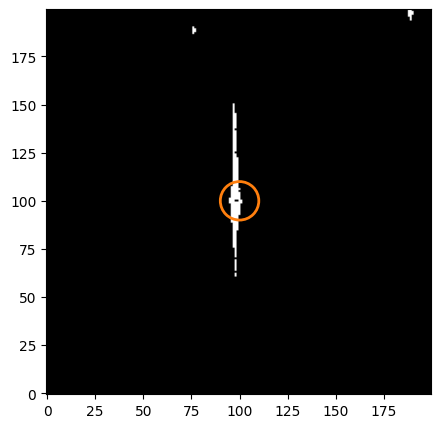

In [26]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)

circ_patch = Circle((cutout_radius, cutout_radius),
                    radius=aperture_radius,
                    color='C1',
                    linewidth=2,
                    fill=False)
ax.imshow(dq_long[cutter], cmap='bone', origin='lower')
ax.add_patch(circ_patch)

Since the saturated pixels extend past our extraction radius, we need to use a different method to improve photometry

<a id="_bleed"></a>
## 3. Bleed the Saturation Mask 

First we need to define a kernel to bleed our saturation mask. We can do this by hand. Since pixels affected by saturation will spill charge along columns, all we need is to convolve our image with a column kernel.

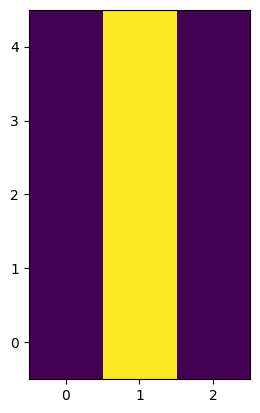

In [27]:
bleed_kernel = np.array([[0, 1, 0],
                         [0, 1, 0],
                         [0, 1, 0],
                         [0, 1, 0],
                         [0, 1, 0]])

plt.imshow(bleed_kernel, origin='lower')

We will use the `scipy` function `convolve2d()` to convolve our cutout with our kernel. Here, `mode='same'` ensures that the returned array is the same shape as the input array.

In [28]:
conv_sat = convolve2d(dq_long[cutter], bleed_kernel, mode='same')

After convolution, we need to convert to a boolean array.

In [29]:
sat_aperture = np.array([x > 0 for x in conv_sat]).astype(bool)

Finally, let's take a look at our mask to make sure it "bled out" properly.

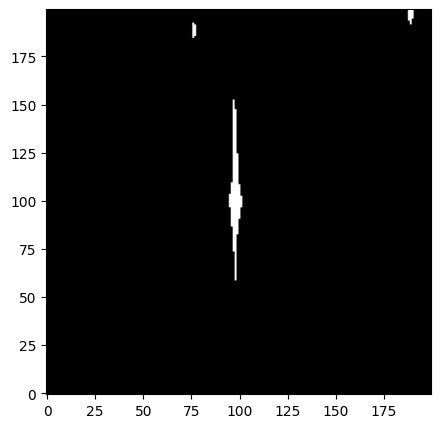

In [30]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)

ax.imshow(sat_aperture, cmap='bone', origin='lower')

<a id="_define"></a>
## 4. Define a Custom Aperture

Now we want to create a new aperture which includes the pixels with the spilled charge. If we want to use the saturation mask we just created, we need to isolate only the clump associated with our star.

Here, we give you a function which will return a mask with only the central clump.

In [31]:
# Isolate associated clump from saturation mask

def find_central_clump(boolean_mask):
    
    print(boolean_mask)
    
    from scipy import ndimage

    central_index = tuple((np.array(np.shape(boolean_mask))/2).astype(int))

    label, num_label = ndimage.label(boolean_mask)
    size = np.bincount(label.ravel())
    
    clump_labels = range(size[1:].shape[0])
    
    is_central_clump = False
    
    for cl in clump_labels:
        
        clump_mask = label == (cl + 1)
        idxs = [tuple(i) for i in np.argwhere(clump_mask)]
        is_central_clump = central_index in idxs

        if is_central_clump:
            
            return clump_mask
        
    if not is_central_clump:
        
        return 0

We can apply this function to our mask to isolate the central clump.

In [32]:
central_clump = find_central_clump(sat_aperture)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


Now we can plot the resulting array to see the clump of interest isolated at the center.

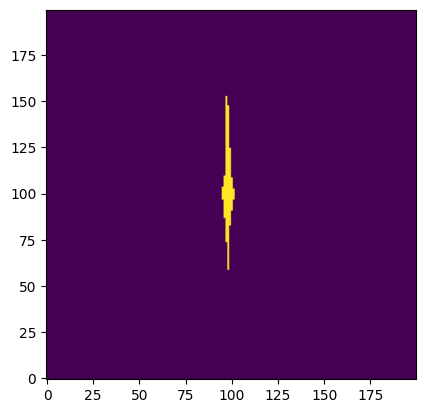

In [33]:
plt.imshow(central_clump, origin='lower')

We can use the package `photutils` to define a circular aperture. To combine it with our mask, we need the circular aperture in mask form. Luckily, this is a built-in feature of aperture objects!

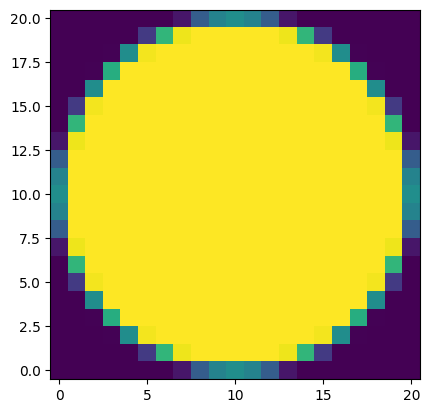

In [34]:
aperture = CircularAperture((cutout_radius, cutout_radius), aperture_radius)
aperture_mask = np.array(aperture.to_mask())

plt.imshow(aperture_mask, origin='lower')

To match the size of our cutout, we can create a new array with our circular aperture at the center

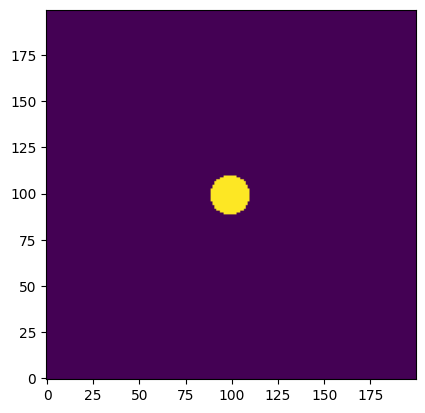

In [35]:
circular_mask = np.zeros(np.shape(sat_aperture))

aperture_dim = np.shape(aperture_mask)
cutout_dim = np.shape(circular_mask)

insert_start = int((cutout_dim[0] - aperture_dim[0]) / 2)
insert_end = int(insert_start + aperture_dim[0])

circular_mask[insert_start:insert_end, insert_start:insert_end] = aperture_mask
    
circular_mask = circular_mask.astype(bool)

plt.imshow(circular_mask, origin='lower')

We can use the `numpy` function `logical_or()` to combine both of our masks to form one boolean array.

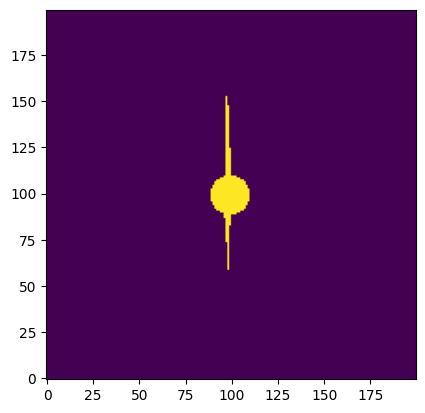

In [36]:
combined_aperture = np.logical_or(central_clump, circular_mask)

plt.imshow(combined_aperture, origin='lower')

<a id="_phot"></a>
## 5. Photometry with a Custom Aperture

Now that we have our custom aperture, let's use that aperture to perform photometry for one source on boht our short and long expsure images.

We'll start with the short exposure image. As before, we will use our cutter to make a cutout around the source.

In [37]:
img_cutout = img_short[cutter]

To obtain the flux in the aperture, all we need to do is to apply the mask to the cutout, and then sum the values.

In [38]:
flux_sum = np.sum(img_cutout[combined_aperture])

To get the local background for each source, we will sigma-clip the image and calculate the median background value. 

In [39]:
bkg_data = sigma_clip(img_cutout, sigma=2, maxiters=10)

We will then estimate the background in our new aperture by multiplying the median by the area covered by the aperture.

In [40]:
new_aperture_area = np.sum(combined_aperture)
bkg_sum = np.median(bkg_data) * new_aperture_area

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Subtract the estimated background from our flux sum, and you're finished!

In [41]:
final_sum_short = flux_sum - bkg_sum

print(final_sum_short)

2456203.852928641


Below, I repeat the photometry steps for this source on the long exposure image.

In [42]:
img_cutout = img_long[cutter]
flux_sum = np.sum(img_cutout[combined_aperture])
bkg_data = sigma_clip(img_cutout, sigma=2, maxiters=10)
bkg_sum = np.median(bkg_data) * new_aperture_area

final_sum_long = flux_sum - bkg_sum

print(final_sum_long)

22957339.14854658


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


If we have recovered the lost flux with our new aperture, our star in the 400 second exposure should have ~10 times the flux as our star in the 40 second exposure.

In [43]:
final_sum_long/final_sum_short

np.float64(9.34667500060043)

<a id="_results"></a>
## 6.  Additional Results

Here we perform all of the photometry steps on a list of three stars. This section of the notebook is intended as a worked example for multiple stars, and therefore will not guide you through each step.

Since we are dealing with photometry of more than one star, it will be convenient to define a table to store information for each star. We will create a column each for x-position, y-position, and the final flux sum for each of the images. We set the table length at 'n' rows for each star, and fill it with zeros to start.

In [44]:
local_coords = [(1711, 225), (1205, 238), (3159, 312)]
n = len(local_coords)

dtype = [('x', 'i4'), 
         ('y', 'i4'), 
         ('flux_short', 'f8'), 
         ('flux_long', 'f8'), 
         ('flux_ratio', 'f8')]

source_table = Table(data=np.zeros(n, dtype=dtype))

source_table['x'] = [c[0] for c in local_coords]
source_table['y'] = [c[1] for c in local_coords]

print(source_table)

 x    y  flux_short flux_long flux_ratio
---- --- ---------- --------- ----------
1711 225        0.0       0.0        0.0
1205 238        0.0       0.0        0.0
3159 312        0.0       0.0        0.0


Below I have condensed the steps of this notebook into functions.

In [45]:
def prepare_images(fname):
    
    pname = os.path.basename(fname).split('.')[0] + '_pam.fits'
    pamutils.pam_from_file(fname, ext=1, output_pam=pname)

    raw_array = fits.getdata(fname)
    pam_array = fits.getdata(pname)
    img_array = raw_array * pam_array

    sat_array = fits.getdata(fname, ext=3) == 256
    
    return img_array, sat_array


def bleed_saturation_mask(sat_array):
    
    bleed_kernel = np.array([[0, 1, 0],
                             [0, 1, 0],
                             [0, 1, 0],
                             [0, 1, 0],
                             [0, 1, 0]])
    
    convolved = convolve2d(sat_array, bleed_kernel, mode='same')
    bled_mask = np.array([x > 0 for x in convolved]).astype(bool)
    
    return bled_mask


def photometry_on_cutout(img_cutout, custom_aperture):
    
    flux_sum = np.sum(img_cutout[custom_aperture])
    bkg_data = sigma_clip(img_cutout, sigma=3, maxiters=10)
    
    aperture_area = np.sum(custom_aperture)
    bkg_flux = np.median(bkg_data) * aperture_area
    
    return flux_sum-bkg_flux

The following cell performs photometry on the three stars.

In [46]:
for row in source_table:

    img_arr_s, _ = prepare_images(fname_short)
    img_arr_l, sat_arr = prepare_images(fname_long)
    sat_mask = bleed_saturation_mask(sat_arr)

    cutter = make_cutter(row['x'], row['y'])

    sat_aperture = find_central_clump(sat_mask[cutter])

    custom_aperture = np.logical_or(sat_aperture, circular_mask)

    row['flux_short'] = photometry_on_cutout(img_arr_s[cutter], custom_aperture)
    row['flux_long'] = photometry_on_cutout(img_arr_l[cutter], custom_aperture)
    
source_table['flux_ratio'] = source_table['flux_long'] / source_table['flux_short']

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Let's take a look at our table...

In [47]:
source_table

x,y,flux_short,flux_long,flux_ratio
int64,int64,float64,float64,float64
1711,225,2456203.862839466,22957339.14854658,9.346674962886434
1205,238,526489.1894441628,5265472.7904016925,10.001103338818178
3159,312,3790974.881916084,34535355.00350445,9.109887582808025


While this method is an improvement for some saturated stars, it still has limitations. We can make a quick plot to show that the percentage of recovered flux decreases for brighter stars.

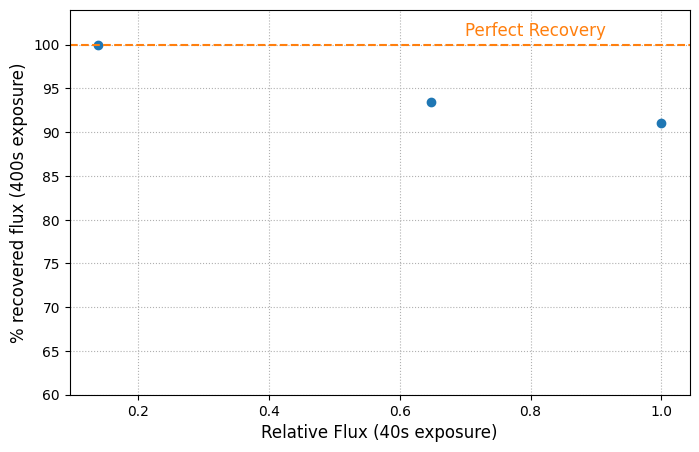

In [48]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.plot(source_table['flux_short']/np.max(source_table['flux_short']),
        source_table['flux_ratio']*10, 'o')

ax.text(.7, 101, 'Perfect Recovery', color='C1', fontsize=12)
ax.set_ylim([60, 104])
ax.set_xlabel('Relative Flux (40s exposure)', fontsize=12)
ax.set_ylabel('% recovered flux (400s exposure)', fontsize=12)
ax.axhline(y=100, linestyle='--', color='C1')
ax.grid(True, linestyle=':')

<a id="about"></a>
## About this Notebook

**Curator:** Yotam Cohen, ACS Instrument Team, Space Telescope Science Institute


### References

http://iopscience.iop.org/article/10.1086/444553



### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](https://hst-docs.stsci.edu/acsdhb).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.

<hr>

[Top of Page](#titleSaturation)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
<br></br>
<br></br>